# Install dependencies.

Pandas for Dataframes

PGMPY for Bayesian Network

In [25]:
! pip install pandas;
! pip install pgmpy;

# Import dependencies

Import Pandas, Bayesian Network, Bayesian Estimator and VariableElimination

In [26]:
# Import Pandas for the Dataframes
import pandas as pd
# Import Pgmpy Modules for Bayesian Network
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Define Constants

Define constants for column names


In [27]:
Quali = "Qualifikation"
S = "Schnitt"
BL = "Bundesland"
M = "Mathe"
P = "Physik"
D = "Deutsch"
ST = "Schultyp"
OLTM = "OLT-Mathe"
OLTD = "OLT-Deutsch"
SFT = "Studierfähigkeitstest"
A = "Alter"
Geschl = "Geschlecht"
JEDE = "Jahreseinkommen der Eltern"
SB = "Staatsbürgerschaft"
SG = "Studiengang"
Absch= "Abschluss"

# Load data and parse

Load data from "p001_1.csv" file and parse non-string variables

In [28]:
# Load data from the "p001_1.csv" file as a dataframe
init_data = pd.read_csv('p001_1.csv', sep=';',dtype="string")

# Function to parse data into acceptable datatypes
def parse_df(data:pd.DataFrame):
    # numerical columns that need to be parsed into a number
    numerical_columns = [S, M, D, P, OLTM, OLTD, SFT, A, JEDE, Absch]
    # format colums that need to be formatted in order to be parsed sucessfully
    format_colums = [S, M, D, P, Absch]

    # Format the required colums, by changing a "," to an "." 
    for column in format_colums:
        if column not in data:
            continue
        data[column] = data[column].str.replace(",",".")

    # Parse string to numeric(int or float)
    for column in numerical_columns:
        if column not in data:
            continue
        data.loc[:, column] = pd.to_numeric(
            data[column], errors="coerce"
        )
    
    # Handle missing values in categorical columns
    categorical_columns = [Quali, BL, ST, Geschl, SB, SG]
    for column in categorical_columns:
        if column not in data:
            continue
        # Replace missing values with the most frequent category
        data.loc[:, column].fillna(data[column].mode()[0], inplace=True)
    
    return data

init_data = parse_df(init_data)

# Transform data 

Modify data to be more digestible and easily usable for the bayesian network

In [29]:
# Map Abschlussnote to "abgebrochen", "gut" or "bestehen"
def map_absch(value):
    #If not a number "abgebrochen"
    if pd.isna(value):
        return("abgebrochen")
    #Range 1-2.4 is "gut"
    elif value < 2.5:
        return("gut")
    #Anything worse then 2.4 is "bestehen"
    else:
        return("bestehen")
                
# Map Age to "Teen", "YoungAdult" or "Adult"
def map_age(value):
    if pd.isna(value):
        return(value)
    elif  value < 20:
        return("Teen")
    elif  value < 25:
        return("YoungAdult")
    else:
        return("Adult")

# Map Grade to "Sehr Gut", "Gut" or "Befriedigend", "Ausreichend" or "mangelhaft"
def map_grade(value):
    if pd.isna(value):
        return(value)
    elif  value < 2:
        return("Sehr Gut")
    elif  value < 3:
        return("Gut")
    elif  value < 4:
        return("Befriedigend")
    elif  value == 4:
        return("Ausreichend")
    else:
        return("mangelhaft")

# Map OLT-Values (Math or German) to "Sehr Gut", "Gut" or "Schlecht"
def map_olt(value):
    if pd.isna(value):
        return(value)
    elif  value < 50:
        return("Schlecht")
    elif  value < 75:
        return("Gut")
    else:
        return("Sehr Gut")

# Map Studienfähigkeitstest to "Sehr Gut", "Gut" or "Schlecht"
def map_sft(value):
    if pd.isna(value):
        return(value)
    elif  value < 600:
        return("Schlecht")
    elif  value < 750:
        return("Gut")
    else:
        return("Sehr Gut")

# Map JahreseinkommenderEltern to "Gering", "Mittel" or "Hoch"
def map_jede(value):
    if pd.isna(value):
        return(value)
    elif value < 60000:
        return("Gering")
    elif value < 100000:
        return("Mittel")
    else: 
        return("Hoch")

# Function to transform all relevant data in the dataframe
def transform_data(data:pd.DataFrame):
    if Absch in data:
        new_absch = []
        for value in data[Absch]:
            new_absch.append(map_absch(value))
        data[Absch] = new_absch

    if A in data:
        new_age = []
        for value in data[A]:
            new_age.append(map_age(value))
        data[A] = new_age

    grades = [M, D, P, S]

    for grade in grades:
        if grade not in data:
            continue
        new_grade = []
        for value in data[grade]:
            new_grade.append(map_grade(value))
        data[grade] = new_grade

    if OLTD in data:
        new_oltd = []
        for value in data[OLTD]:
            new_oltd.append(map_olt(value))
        data[OLTD] = new_oltd

    if OLTM in data:
        new_oltm = []
        for value in data[OLTM]:
            new_oltm.append(map_olt(value))
        data[OLTM] = new_oltm

    if SFT in data:
        new_sft = []
        for value in data[SFT]:
            new_sft.append(map_sft(value))
        data[SFT] = new_sft

    if JEDE in data:
        new_jede = []
        for value in data[JEDE]:
            new_jede.append(map_jede(value))
        data[JEDE] = new_jede

    return data

init_data = transform_data(init_data)

# Create Bayesian Network

Create Bayesian Network with nodes and edges and fitting it with the data from the csv

Because the data set is very small and not meaningful enough, we decided to configure the Bayesian network ourselves and not to create a correlation matrix

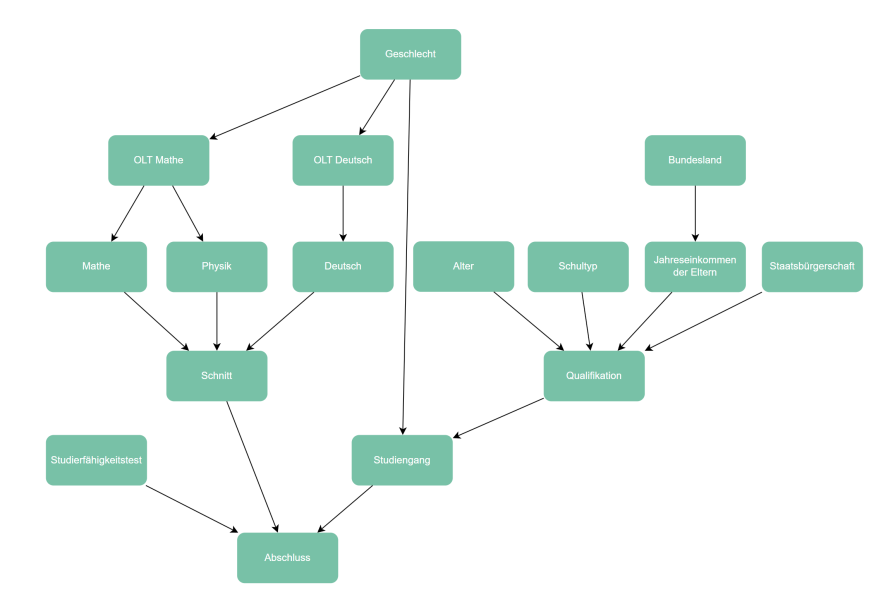

In [30]:
# Create Bayesian Network
G = BayesianNetwork()
# Add the necessary colums from the dataframe into the network
G.add_nodes_from(init_data.columns)
display(init_data)

# Add all edges to the network
G.add_edges_from([
    (Geschl, OLTM),     # The "Geschlecht" affects the Grade in "OLT-Mathe", given that males tend to be better at "Mathe"
    (Geschl, OLTD),     # The "Geschlecht" affects the Grade in "OLT-Deutsch", given that females tend to be better at "Deutsch"
    (OLTM, M),          # The "OLT-Mathe" Grade affects the "Mathe" Grade, given that both have the same Subject "Mathe"
    (OLTM, P),          # The "OLT-Mathe" Grade affects the "Physik" Grade, given that both are a part of STEM
    (OLTD, D),          # The "OLT-Deutsch" Grade affects the "Deutsch" Grade, given that both have the same Subject "Deutsch"
    (M, S),             # The "Mathe" Grade affects the "Schnitt", given that it is a part of the calculation
    (P, S),             # The "Physik" Grade affects the "Schnitt", given that it is a part of the calculation
    (D, S),             # The "Deutsch" Grade affects the "Schnitt", given that it is a part of the calculation
    (SFT, Absch),       # The "Studienfähigkeitstest" affects the "Abschluss", given that it is a rough estimate on how well one will pass
    (S, Absch),         # The "Schnitt" affects the "Abschluss", given that it is a reference for how well the person did in school
    (Geschl, SG),       # The "Geschlecht" affects the "Studiengang", given that males tend to choose STEM-Majors and females choose Business-Majors
    (SG, Absch),        # The "Studiengang" affects the "Abschluss", given that they have differnent complexities and requirements
    (A, Quali),         # The "Age" affects the "Qualifikation", given that younger people have less chances to get higher qualification
    (ST, Quali),        # The "Schultyp" affects the "Qualifikation", as certain schooltypes give different qualifications
    (BL, JEDE),         # The "Bundesland" affects the "Jahreseinkommen der Eltern", as certain locations have a higher median income
    (JEDE, Quali),      # The "Jahreseinkommen der Eltern" affects the "Qualifikation", as the income of a family affects the education
    (SB, Quali),        # The "Staatsbürgerschaft" affects the "Qualifikation", as the ethnicity of person can affects their education 
    (Quali, SG)         # The "Qualifikation" affects the "Studiengang", as certain majors have strict requirements for qualifications
])

# Use BayesianEstimator to learn the CPDs
G.fit(data=init_data, estimator=BayesianEstimator)

Qualifikation   Schnitt           Bundesland     Mathe    Physik   Deutsch  \
0         Abitur       Gut    Baden-Württemberg       Gut       Gut       Gut   
1        Meister  Sehr Gut  Nordrhein-Westfalen      <NA>      <NA>      <NA>   
2         Abitur  Sehr Gut    Baden-Württemberg  Sehr Gut  Sehr Gut  Sehr Gut   
3         Abitur  Sehr Gut    Baden-Württemberg       Gut       Gut  Sehr Gut   
4         Abitur  Sehr Gut               Bayern       Gut       Gut  Sehr Gut   
..           ...       ...                  ...       ...       ...       ...   
95        Abitur  Sehr Gut    Baden-Württemberg       Gut       Gut       Gut   
96        Abitur       Gut    Baden-Württemberg  Sehr Gut  Sehr Gut  Sehr Gut   
97        Abitur  Sehr Gut    Baden-Württemberg       Gut       Gut  Sehr Gut   
98        Abitur       Gut               Bayern  Sehr Gut  Sehr Gut  Sehr Gut   
99        Abitur       Gut    Baden-Württemberg  Sehr Gut      <NA>  Sehr Gut   

                        Schultyp OLT-Mathe OLT-Deutsch Studierfähigkeitstest  \
0   Allgemeinbildendes Gymnasium       Gut         Gut                   Gut   
1                           n.a.  Schlecht         Gut                  <NA>   
2           Wirtschaftsgymnasium  Sehr Gut    Sehr Gut                  <NA>   
3          Technisches Gymnasium       Gut    Sehr Gut                  <NA>   
4           Wirtschaftsgymnasium       Gut    Sehr Gut                  <NA>   
..                           ...       ...         ...                   ...   
95  Allgemeinbildendes Gymnasium       Gut         Gut                   NaN   
96         Technisches Gymnasium  Sehr Gut    Sehr Gut                   NaN   
97         Technisches Gymnasium  Sehr Gut    Sehr Gut                   NaN   
98  Allgemeinbildendes Gymnasium  Sehr Gut    Sehr Gut                   NaN   
99  Allgemeinbildendes Gymnasium       Gut         Gut                   NaN   

         Alter Geschlecht Jahreseinkommen der Eltern Staatsbürgerschaft  \
0         Teen          m                     Gering            deutsch   
1        Adult          m                     Mittel            deutsch   
2         Teen          w                       Hoch            deutsch   
3         Teen          m                       Hoch            deutsch   
4         Teen          m                     Mittel            deutsch   
..         ...        ...                        ...                ...   
95        Teen          w                       Hoch            deutsch   
96  YoungAdult          m                     Mittel            deutsch   
97        Teen          m                       Hoch            deutsch   
98        Teen          m                       Hoch            deutsch   
99  YoungAdult          m                     Mittel            deutsch   

                  Studiengang    Abschluss  
0                Maschinenbau     bestehen  
1                Maschinenbau  abgebrochen  
2              Soziale Arbeit          gut  
3              Elektrotechnik     bestehen  
4              Elektrotechnik          gut  
..                        ...          ...  
95             Elektrotechnik     bestehen  
96  Wirtschaftswissenschaften          gut  
97               Maschinenbau          gut  
98               Maschinenbau          gut  
99             Soziale Arbeit          gut  

[100 rows x 16 columns]

# Test prediction

Makes a test prediction to verify the Bayesian Network

In [31]:
# Perform inference with incomplete input
# Example: Predict Abschluss for a student with Qualifikation = "Abitur",
# Schultyp = "Allgemeinbildendes Gymnasium", BL = "Baden-Württemberg",
# and A = 22
evidence = {
    Quali: "Abitur",
    ST: "Allgemeinbildendes Gymnasium",
    BL: "Baden-Württemberg",
    A: "Adult"
}

# Use Variable Elimination to make predictions
infer = VariableElimination(G)
q = infer.query(variables=[Absch], evidence=evidence)
print(q)

+------------------------+------------------+
| Abschluss              |   phi(Abschluss) |
+========================+==================+
| Abschluss(abgebrochen) |           0.2915 |
+------------------------+------------------+
| Abschluss(bestehen)    |           0.3637 |
+------------------------+------------------+
| Abschluss(gut)         |           0.3448 |
+------------------------+------------------+


# Run with data from test file

Loads "new_data.csv" and runs a prediction using the created model

In [33]:
#Load data from "new_data.csv" 
test_data = pd.read_csv('new_data.csv', sep=';',dtype=str)

#Set empty Colums to NA
for column in test_data.columns:
    if test_data[column][0] == "":
        test_data[column][0] = pd.NA

#Parse and transform raw data
test_data = parse_df(test_data)
test_data = transform_data(test_data)

#Remove NA Columns
for column in test_data.columns:
    if pd.isna(test_data[column][0]):
        test_data = test_data.drop(columns=column)

# Use Variable Elimination to make prediction
infer = VariableElimination(G)
q = infer.query(variables=[Absch], evidence=test_data.to_dict(orient='records')[0])
print(q)

+------------------------+------------------+
| Abschluss              |   phi(Abschluss) |
+========================+==================+
| Abschluss(abgebrochen) |           0.0333 |
+------------------------+------------------+
| Abschluss(bestehen)    |           0.9333 |
+------------------------+------------------+
| Abschluss(gut)         |           0.0333 |
+------------------------+------------------+
